In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.gridspec as gs
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Polygon
import scipy.stats as stats

pd.options.display.float_format = '{:.5f}'.format

In [2]:
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

In [ ]:
src = "../data/"

In [ ]:
with open(join(src, "dtypes_config.pickle"), "rb") as file:
    DTYPES = pkl.load(file)

## COVARIATES PANEL

In [ ]:
df_starters = pd.read_csv(join(src,
                              "discussions_starters_aggregates.csv"),
                 usecols=["Rating", "id", "created_at",
                          "anger", "fear", "disgust", "sadness",
                          "joy", "pride", "hope"
                          ],
                          dtype=DTYPES)

len(df_starters)

9906259

In [6]:
# capitalize emotions
df_starters.columns = [col.capitalize() for col in df_starters.columns]

In [7]:
emotions = ["Anger", "Fear",
            "Disgust", "Sadness",
            "Joy", "Pride", "Hope"]

df_starters["Created_at"] = pd.to_datetime(df_starters["Created_at"])
df_starters["Day"] = df_starters["Created_at"].dt.date
df_starters["Week"] = df_starters["Created_at"].dt.to_period("W")

df_emotions_daily = df_starters.groupby("Day")[emotions].mean()

/tmp/ipykernel_3323813/4286943826.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_starters["Week"] = df_starters["Created_at"].dt.to_period("W")


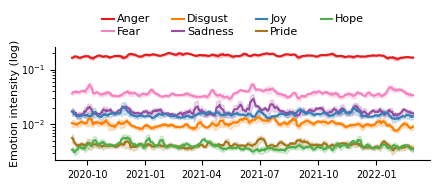

In [ ]:
emotion_colormap = {
    "Anger": "#e41a1c",
    "Fear": "#f781bf",
    "Disgust": "#ff7f00",
    "Sadness": "#984ea3",
    "Joy": "#377eb8",
    "Pride": "#a6761d",
    "Hope": "#4daf4a"
}

df_weekly = df_emotions_daily.rolling(window=7).mean()
std_error = df_emotions_daily.rolling(window=7).std() / np.sqrt(7)

ci_multiplier = 1.96 
df_ci_upper = df_weekly + ci_multiplier * std_error
df_ci_lower = df_weekly - ci_multiplier * std_error

fig, ax = plt.subplots(figsize=(4.5, 2))

df_weekly.plot(ax=ax, color=emotion_colormap, legend=False)
for emotion in emotions:
    ax.fill_between(df_weekly.index, df_ci_lower[emotion], df_ci_upper[emotion],
                    color=emotion_colormap[emotion], alpha=0.2)


ax.set_xlabel("", fontsize=8, labelpad=1)
ax.set_ylabel("Emotion intensity (log)", fontsize=8, labelpad=1)
ax.set_yscale("log")
ax.tick_params(axis="both", labelsize=7)


dates = pd.date_range(start=df_weekly.index.min(), 
                      end=df_weekly.index.max(), 
                      freq='3ME')  
ax.set_xticks(dates)
ax.set_xticklabels(dates.strftime('%Y-%m'))


ax.legend(loc='lower left', 
          bbox_to_anchor=(0.1, 1), 
          ncol=4,
          frameon=False,
          handlelength=1,
          handletextpad=0.3,
          labelspacing=0.2,
          fontsize=8)

custom_plots(ax=ax)

plt.tight_layout()
plt.savefig("emotions_over_time.pdf", dpi=300)
plt.show()

In [ ]:
df_discussions = pd.read_csv(
    join(src, 
         "discussions_replies_aggregates.csv"),
    usecols=lambda col: col not in ['domain'],
    dtype=DTYPES
)

emotions = ["anger", "fear",
            "disgust", "sadness",
            "joy", "pride", "hope"]

df_discussions = df_discussions.rename(columns={emo: emo.capitalize() + "*" for emo in emotions})

df_discussions.columns

Index(['conversation_id', 'author_id', 'created_at', 'author.followers_count',
       'author.following_count', 'author.tweet_count', 'Rating', 'Score',
       'Anger*', 'Fear*', 'Disgust*', 'Sadness*', 'Joy*', 'Pride*', 'Hope*',
       'Orientation', 'word_count', 'word_count_log', 'author.tweet_count_log',
       'author.followers_count_log', 'author.following_count_log', 'anger_log',
       'fear_log', 'disgust_log', 'sadness_log', 'joy_log', 'pride_log',
       'hope_log', 'anger_avg', 'fear_avg', 'disgust_avg', 'sadness_avg',
       'joy_avg', 'pride_avg', 'hope_avg', 'author.tweet_count_avg',
       'author.tweet_count_avg_log', 'time_diff', 'time_diff_log'],
      dtype='object')

In [10]:
selected_columns = [
    "Anger*", "Fear*", "Disgust*", "Sadness*",
    "Joy*", "Pride*", "Hope*", 
    "word_count_log",
    "time_diff_log",
    "author.tweet_count_log", "author.followers_count_log",
    "author.following_count_log", "anger_log", "fear_log", 
    "disgust_log", "sadness_log", "joy_log", "pride_log", "hope_log"
]
df_covariates = df_discussions[selected_columns]

df_covariates.columns = (
    df_covariates.columns
    .str.replace("author.followers_count_log", "Followers", regex=False) 
    .str.replace("author.following_count_log", "Following", regex=False)  
    .str.replace("author.tweet_count_log", "Tweet count", regex=False) 
    .str.replace("word_count_log", "Word count", regex=False)
    .str.capitalize() 
    .str.replace("Time_diff_log", "DTS", regex=False)
    .str.replace("_log", "")
)

df_covariates.columns

Index(['Anger*', 'Fear*', 'Disgust*', 'Sadness*', 'Joy*', 'Pride*', 'Hope*',
       'Word count', 'DTS', 'Tweet count', 'Followers', 'Following', 'Anger',
       'Fear', 'Disgust', 'Sadness', 'Joy', 'Pride', 'Hope'],
      dtype='object')

In [11]:
y_vars = ["Anger", "Fear", 
          "Disgust", "Sadness",
          "Joy", "Pride", "Hope",
          "Word count",
          "Tweet count", 
          "DTS",
          "Followers",
          "Following"]

x_vars = ["Anger*", "Fear*", "Disgust*", "Sadness*",
          "Joy*", "Pride*", "Hope*"]

corr = df_covariates[y_vars + x_vars].corr()

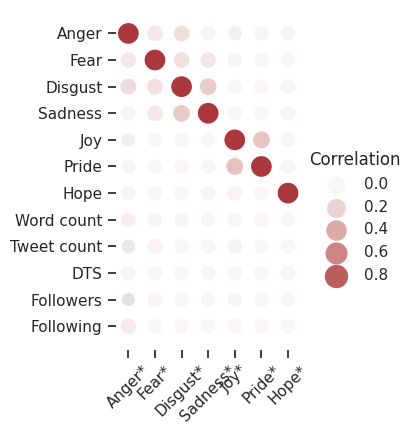

In [ ]:
sns.set_theme(style="whitegrid")

corr_mat =corr.loc[x_vars, y_vars].stack().reset_index(name="Correlation")
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor="1",
    height=4.5, 
    aspect=4/4.5,
    sizes=(100, 250), 
    size_norm=(-.2, .8),
)

g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.08)
for label in g.ax.get_xticklabels():
    label.set_rotation(45)

emotions = ["Anger", "Fear",
            "Disgust", "Sadness",
            "Joy", "Pride", "Hope"]

custom_plots(ax=g.ax)
plt.tight_layout()
plt.savefig("covariates_correlation.pdf", dpi=300)
plt.show()

In [13]:
barplot_map = ["#1b9e77", "#7570b3"]

df_rating = df_starters\
    .groupby(["Week", "Rating"])\
        .size().unstack().fillna(0)

df_rating = df_rating.div(df_rating.sum(axis=1), axis=0)

# aggregate the average across time and the std
df_rating_agg = df_rating.agg(["mean", "std"]).T.round(3)

# multiply by 100 to get percentage
df_rating_agg = df_rating_agg * 100
df_rating_agg.index = ["Trustworthy", "Untrustworthy"]
df_rating_agg

,mean,std
Trustworthy,94.00000,0.60000
Untrustworthy,6.00000,0.60000


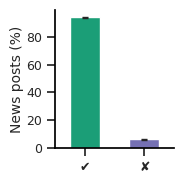

In [14]:
fig, ax = plt.subplots(figsize=(2, 2))
ax = df_rating_agg.plot(kind="bar", 
                   y="mean", yerr="std", 
                   color=barplot_map, 
                   capsize=2,
                   ax=ax)

# no legend
ax.legend().set_visible(False)
ax.set_xticklabels([u"\u2714",u"\u2718"], 
                        rotation=0,
                        fontsize=10)
ax.set_ylabel("News posts (%)", 
                   fontsize=10,
                   labelpad=1.5)
ax.tick_params(axis="both", labelsize=9)
custom_plots(ax=ax)
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_position('left')
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## CAUSAL EFFECTS FIGURE

In [ ]:
coeffs_dtypes = {
    "Coefficient": float, 
    "CI_Lower": float, 
    "CI_Upper": float
}

def process_coeffs(path, dtypes):
    df = pd.read_csv(path, dtype=dtypes)
    df["DV"] = df["DV"].str.replace("_avg", "").str.replace("_first", "")
    return df

replies_coeffs = process_coeffs("./replies/replies_coeffs.csv", coeffs_dtypes)
replies_coeffs_boot = process_coeffs("./replies/replies_res_boot.csv", coeffs_dtypes)
first_coeffs = process_coeffs("./replies_first/replies_first_coeffs.csv", coeffs_dtypes)
first_coeffs_boot = process_coeffs("./replies_first/replies_first_res_boot.csv", coeffs_dtypes)

replies_coeffs['significant'] = replies_coeffs["P-Value"] < 0.05
first_coeffs['significant'] = first_coeffs["P-Value"] < 0.05
replies_coeffs

,DV,Coefficient,SE,CI_Lower,CI_Upper,P-Value,R-Squared,Cond_Mean,significant
0,Anger,0.03132,0.00243,0.02655,0.03608,0.00000,0.01552,0.36862,True
1,Disgust,0.00359,0.00058,0.00246,0.00472,0.00000,0.00565,0.01718,True
2,Fear,0.00185,0.00052,0.00082,0.00288,0.00042,0.00575,0.01503,True
3,Sadness,0.00092,0.00058,-0.00021,0.00206,0.10908,0.01328,0.01763,False
4,Joy,-0.00361,0.00087,-0.00531,-0.00191,0.00003,0.00808,0.03202,True
5,Pride,-0.00032,0.00026,-0.00083,0.00019,0.22073,0.00133,0.00527,False
6,Hope,-0.00008,0.00037,-0.00080,0.00063,0.81903,0.00157,0.00749,False


In [16]:
# take lower and upper percentile of the bootstrapped coefficients
def take_percentile(df):
    df_perc = df.groupby("DV")["Coefficient_boot"].quantile([0.025, 0.975]).unstack()
    df_perc.columns = ["CI_Lower_boot", "CI_Upper_boot"]
    df_perc = df_perc.reset_index()
    df['DV'] = df['DV'].astype(str)
    df_perc.columns = ["Emotion", "CI_Lower_boot", "CI_Upper_boot"]
    return df_perc

replies_boot_ci = take_percentile(replies_coeffs_boot)
first_boot_ci = take_percentile(first_coeffs_boot)
replies_boot_ci

,Emotion,CI_Lower_boot,CI_Upper_boot
0,Anger,0.02659,0.03608
1,Disgust,0.00247,0.00474
2,Fear,0.00084,0.00289
3,Hope,-0.00079,0.00063
4,Joy,-0.00532,-0.00190
5,Pride,-0.00084,0.00019
6,Sadness,-0.00020,0.00205


In [17]:
# standardize the column and dv names 
def standardize_names(df):
    df["DV"] = df["DV"].str.replace("_first", "").str.replace("_avg", "")
    df["DV"] = df["DV"].str.capitalize()
    df['DV'] = df['DV'].astype(str)
    df.rename(columns={"DV": "Emotion"}, inplace=True)
    return df

replies_coeffs = standardize_names(replies_coeffs)
first_coeffs = standardize_names(first_coeffs)

In [19]:
# add bootstrapped CI to the dataframes
replies_coeffs = replies_coeffs.merge(replies_boot_ci, on="Emotion")
first_coeffs = first_coeffs.merge(first_boot_ci, on="Emotion")

In [ ]:
# sort according to Coefficient
replies_coeffs = replies_coeffs.sort_values("Coefficient")
first_coeffs = first_coeffs.sort_values("Coefficient")

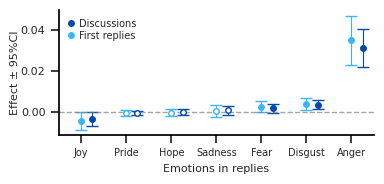

In [21]:
df_colormap = {
    "Discussions": "#004aad",
    "First replies": "#38b6ff"}

def plot_emotion_coefficients(ax, replies_coeffs, first_coeffs, 
                              df_colormap, 
                              custom_plots=None):
    
    emotion_categories = replies_coeffs["Emotion"].unique()
    emotion_positions = {emotion: i for i, emotion in enumerate(emotion_categories)}
    
    replies_coeffs = replies_coeffs.copy()
    first_coeffs = first_coeffs.copy()
    replies_coeffs["Emotion_Pos"] = replies_coeffs["Emotion"].map(emotion_positions)
    first_coeffs["Emotion_Pos"] = first_coeffs["Emotion"].map(emotion_positions)

    for i, row in replies_coeffs.iterrows():
        color = df_colormap["Discussions"] if row["significant"] else "white"
        ax.errorbar(row["Emotion_Pos"] + 0.25, 
                   row["Coefficient"],
                   yerr=row["CI_Upper_boot"] - row["CI_Lower_boot"],
                   fmt='o', 
                   color=color,
                   ecolor=df_colormap["Discussions"],
                   markeredgecolor=df_colormap["Discussions"],
                   markersize=4, elinewidth=0.8, capsize=4,
                   label="Discussions")

    for i, row in first_coeffs.iterrows():
        color = df_colormap["First replies"] if row["significant"] else "white"
        ax.errorbar(row["Emotion_Pos"], 
                   row["Coefficient"],
                   yerr=row["CI_Upper_boot"] - row["CI_Lower_boot"],
                   fmt='o', color=color,
                   ecolor=df_colormap["First replies"],
                   markeredgecolor=df_colormap["First replies"],
                   markersize=4, elinewidth=0.8, capsize=4,
                   label="First replies")
    
    
    ax.axhline(0, color="gray", linestyle="--", linewidth=1, alpha=0.7)
    ax.set_ylabel("Effect ± 95%CI", fontsize=8, labelpad=0.5)  
    ax.set_xlabel("Emotions in replies", fontsize=8)
    ax.set_xticks(list(emotion_positions.values()))
    ax.set_xticklabels(emotion_categories, fontsize=7)
    ax.tick_params(axis="y", labelsize=8)
    ax.set_xlim(-0.5, len(emotion_categories) - 0.5)

    custom_plots(ax=ax)

    legend_handles = []
    
    discussions_marker = mlines.Line2D([], [], 
                                      color=df_colormap["Discussions"], 
                                      marker='o', markersize=6, 
                                      markeredgecolor="w", 
                                      linestyle="None", 
                                      label="Discussions")
    legend_handles.append(discussions_marker)
    
    first_replies_marker = mlines.Line2D([], [], 
                                        color=df_colormap["First replies"], 
                                        marker='o', markersize=6, 
                                        markeredgecolor="w", 
                                        linestyle="None", 
                                        label="First replies")
    legend_handles.append(first_replies_marker)
    
    
    ax.legend(handles=legend_handles, 
             loc="upper left", 
             fontsize=7, 
             frameon=False,
             handlelength=0.75,
             handletextpad=0.4, labelspacing=0.2)
    
    return ax

fig1, ax1 = plt.subplots(figsize=(4, 2))
plot_emotion_coefficients(ax1, replies_coeffs, first_coeffs, df_colormap,
                          custom_plots=custom_plots)

plt.tight_layout()

In [ ]:
def import_means(dv):
    means = pd.read_csv(f"./engagement/{dv}_count_means_summary.csv") 
    means["DV"] = dv
    means["DV"] = means["DV"].str.capitalize()
    return means

like_means = import_means("like")
quote_means = import_means("quote")
reply_means = import_means("reply")
retweet_means = import_means("retweet")

means = pd.concat([like_means, quote_means, reply_means, retweet_means], ignore_index=True)
means["DV"] = means["DV"].str.capitalize()
means.group = means.group.replace({0: "Trustworthy", 1: "Untrustworthy"})

means = means.rename(columns={
    "group": "Rating",
    "original_mean": "Mean",
    "ci_lower": "pLL",
    "ci_upper": "pUL"
})
means

,Rating,Mean,bootstrap_mean,pLL,pUL,DV
0,Trustworthy,6.38599,6.38553,6.22568,6.54706,Like
1,Untrustworthy,7.06593,7.06675,6.87928,7.25695,Like
2,Trustworthy,0.21473,0.21469,0.20925,0.22020,Quote
3,Untrustworthy,0.23058,0.23062,0.22638,0.23508,Quote
4,Trustworthy,0.77714,0.77713,0.76099,0.79353,Reply
5,Untrustworthy,0.75627,0.75634,0.74200,0.77147,Reply
6,Trustworthy,1.78438,1.78426,1.74026,1.82975,Retweet
7,Untrustworthy,2.64501,2.64538,2.58857,2.70460,Retweet


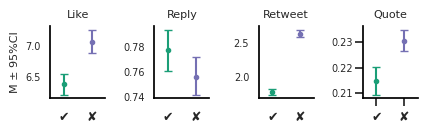

In [23]:
rating_cmap = {
    "Trustworthy": "#1b9e77",
    "Untrustworthy": "#7570b3"
}
def plot_engagement_means(ax, dv_data, dv_name, rating_cmap=None, 
                                 custom_plots=None, show_ylabel=True):
    
    for rating in dv_data["Rating"].unique():
        rating_data = dv_data[dv_data["Rating"] == rating]
        mean_val = rating_data["Mean"].iloc[0]
        pll_val = rating_data["pLL"].iloc[0]
        pul_val = rating_data["pUL"].iloc[0]

        ax.errorbar(
            x=rating, 
            y=mean_val, 
            yerr=[[mean_val - pll_val], [pul_val - mean_val]],
            fmt="o-", 
            markersize=3, 
            capsize=3, 
            color=rating_cmap[rating],
            label=dv_name if rating == 0 else None
        )

    ax.set_xlabel("", fontsize=8)
    ax.set_ylabel("M ± 95%CI", fontsize=8) if show_ylabel else ax.set_ylabel("")
    ax.tick_params(axis="both", which="major", labelsize=7)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([u"\u2714", u"\u2718"], fontsize=9)
    ax.set_xlim(-0.5, 1.5)
    ax.yaxis.set_tick_params(pad=0.8)
    ax.set_title(dv_name, fontsize=8)
    
    custom_plots(ax=ax)
    
    return ax

fig, axs = plt.subplots(1, 4, figsize=(4.5, 1.5))
dv_list = ["Like", "Reply", "Retweet", "Quote"]
for i, dv in enumerate(dv_list):
    ax = axs[i]
    dv_data = means[means["DV"] == dv]
    plot_engagement_means(ax, dv_data, dv, rating_cmap=rating_cmap, 
                          custom_plots=custom_plots, show_ylabel=(i == 0))
plt.tight_layout()
plt.show()

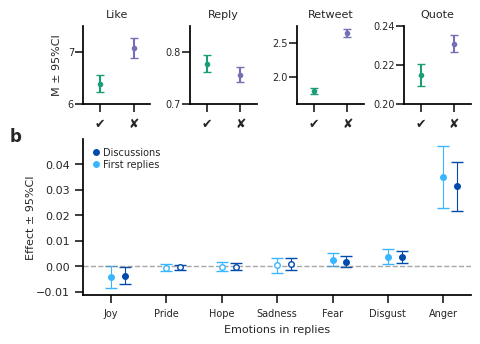

In [ ]:
fig = plt.figure(figsize=(5, 3.5))
gs = fig.add_gridspec(2, 4, 
              figure=fig,
              height_ratios=[0.5, 1],
              width_ratios=[1, 1, 1, 1],
              wspace=0.6, 
              hspace=0.3)

# PLOT A: Engagement means for each DV
for i, dv in enumerate(["Like", "Reply", "Retweet", "Quote"]):
    ax = fig.add_subplot(gs[0, i])  
    dv_data = means[means["DV"] == dv]
    plot_engagement_means(ax, dv_data, dv, rating_cmap=rating_cmap, 
                          custom_plots=custom_plots, show_ylabel=(i == 0))

    if dv == "Like":
        ax.set_ylim(ymin=6, ymax=7.5)
        ax.set_yticks([6, 7])  
    elif dv == "Retweet":
        ax.set_ylim(ymin=1.6, ymax=2.75)
        ax.set_yticks([2, 2.5])  
    elif dv == "Reply":
        ax.set_ylim(ymin=0.7, ymax=0.85)
        ax.set_yticks([0.7, 0.8]) 
    else:
        ax.set_ylim(ymin=0.2, ymax=0.24)
        ax.set_yticks([0.2, 0.22, 0.24]) 

    ax.set_title(dv, fontsize=8)
    custom_plots(ax=ax)


# add titles
ax1.set_title("a", loc="left", 
              fontweight="bold",
              fontsize=12, x=-0.2, y=1.75)

# PLOT B: Emotion coefficients for replies and first replies
ax1 = fig.add_subplot(gs[1, :])  

plot_emotion_coefficients(ax1, replies_coeffs, first_coeffs, 
                          df_colormap,
                          custom_plots=custom_plots)

fig.text(-0.01, 0.55, "b", 
         fontweight="bold",
         ha="center", 
         fontsize=12)

plt.savefig("causal_effects.pdf", 
        dpi=300,
        bbox_inches='tight')

plt.show()

## USER FIGURE

In [ ]:
ratings = pd.read_csv("./users/users_ratings_coeffs.csv")
ratings["Symbol"] = ratings["p"].apply(
    lambda x: "***" if x < 0.001 else "**" if x < 0.01 else "*" if x < 0.05 else ""
)
ratings['IV'] = 'Rating'
sig_ratings = ratings[ratings['p'] < 0.05].copy()
anger = ratings[ratings['DV'] == 'Anger'].copy()
sig_ratings = pd.concat([sig_ratings, anger], ignore_index=True)

all_sig_coeffs = pd.read_csv("./users/users_sig_coeffs.csv")

all_sig_coeffs["IV"] = all_sig_coeffs["IV"]\
    .str.replace("author.", "")\
    .str.replace("_log", "")\
    .str.replace("_", " ")\
    .str.capitalize()\
    .replace("Followers count", "Followers")

all_sig_coeffs["Symbol"] = all_sig_coeffs["p"]\
    .apply(lambda x: "***" 
           if x < 0.001 else "**" 
           if x < 0.01 else "*" 
           if x < 0.05 else ""
)
merged_ratings = pd.concat([sig_ratings, all_sig_coeffs], ignore_index=True)
merged_ratings

,DV,Estimate,SE,t,p,pLL,pUL,Symbol,IV
0,Disgust,0.00696,0.00320,2.17506,0.02970,0.00080,0.01313,*,Rating
1,Fear,0.00670,0.00286,2.34410,0.01914,0.00100,0.01229,*,Rating
2,Pride,-0.00402,0.00165,-2.44097,0.01470,-0.00708,-0.00080,*,Rating
3,Anger,0.01956,0.01309,1.49401,0.13527,-0.00574,0.04490,,Rating
4,Anger,0.16520,0.02114,7.81267,0.00000,0.12628,0.20660,***,Anger
5,Anger,0.24107,0.09266,2.60157,0.00931,0.06686,0.41398,**,Disgust
6,Anger,0.19317,0.08412,2.29635,0.02170,0.03642,0.35386,*,Sadness
7,Anger,-0.40791,0.18858,-2.16311,0.03058,-0.75811,-0.02887,*,Hope
8,Anger,-0.00871,0.00420,-2.07127,0.03843,-0.01667,-0.00097,*,Followers
9,Disgust,0.00696,0.00320,2.17506,0.02970,0.00080,0.01313,*,Rating


In [ ]:
df_replies = pd.read_csv(join(src, 
                            "discussions_replies.csv.gz"), 
                            compression='gzip',
                            usecols=[
                            'conversation_id', 'author_id', 
                            'author.tweet_count', 
                            'anger', 'fear', 'disgust', 
                            'Score', 'Orientation']
                    )\
                .merge(df_discussions[["conversation_id", "Rating"]],
                            on='conversation_id', how='right')
len(df_replies), df_replies.conversation_id.nunique()

(11688608, 852206)

In [27]:
df_replies['Rating'] = df_replies['Rating'].astype(str)\
    .replace({'0.0':'Trustworthy', 
              '1.0':'Untrustworthy'})
df_replies.Rating.value_counts(dropna=False)

Rating
Trustworthy      11237196
Untrustworthy      451412
Name: count, dtype: int64

In [ ]:
users_agg = pd.read_csv(join(src,
                            "all_users_aggregated.csv"),
                        usecols=[
                                'author_id', 'user_anger', 
                                'user_fear', 'user_disgust',
                                'user_score',
                                'user_orientation'],
                         dtype={
                                'author_id': str,
                                'user_anger': float,
                                'user_score': float,
                                'user_fear': float,
                                'user_disgust': float,
                                'user_orientation': str
                         })
users_agg

,author_id,user_score,user_anger,user_fear,user_disgust,user_orientation
0,2808,87.50000,0.00207,0.00220,0.00044,Neutral
1,3669,96.87500,0.00766,0.00202,0.00071,Left
2,4228,100.00000,0.00527,0.00190,0.00233,Left
3,4560,95.00000,0.00562,0.00054,0.00045,Right
4,5267,93.12500,0.37221,0.00822,0.01534,Neutral
...,...,...,...,...,...,...
518039,1639688851667992578,NaN,0.99347,0.00370,0.00477,NaN
518040,1643990453585588226,NaN,0.20376,0.01878,0.00272,NaN
518041,1644322302048313344,NaN,0.06334,0.00027,0.00031,NaN
518042,1646214102551756828,NaN,0.73027,0.00092,0.00175,NaN


In [29]:
def summarize_authors(df):
    n_replies = len(df)

    author_freq = df['author_id']\
                    .value_counts()\
                    .reset_index()\
                    .rename(columns={
                        'count': 'n_replies'})

    # calculate cumulative percentage
    author_freq = author_freq.sort_values('n_replies', 
                                          ascending=False)\
                             .reset_index(drop=True)
    author_freq['cum_replies'] = author_freq['n_replies'].cumsum()
    author_freq['cum_perc'] = author_freq['cum_replies'] / n_replies * 100
    author_freq['user_perc'] = (np.arange(len(author_freq)) + 1) / len(author_freq) * 100

    cutoff = np.argmax(author_freq["cum_perc"] >= 80)
    p_80 = author_freq.iloc[cutoff]["user_perc"]

    return author_freq, cutoff, p_80


total_users, total_cutoff, total_perc = summarize_authors(df_replies)

untrust_replies = df_replies[df_replies['Rating'] == 'Untrustworthy']
trust_replies = df_replies[df_replies['Rating'] == 'Trustworthy']

untrust_users, untrust_cutoff, untrust_perc = summarize_authors(untrust_replies)
trust_users, trust_cutoff, trust_perc = summarize_authors(trust_replies)

# extract the top users based on cutoff
untrust_users['author_id'] = untrust_users['author_id'].astype(str)
trust_users['author_id'] = trust_users['author_id'].astype(str)

top_untrust = untrust_users.iloc[:untrust_cutoff]\
                    .merge(users_agg, on="author_id", how="left")

top_trust = trust_users.iloc[:trust_cutoff]\
                    .merge(users_agg, on="author_id", how="left")

top_untrust["group"] = "Untrustworthy"
top_trust["group"] = "Trustworthy"
top_users = pd.concat([top_untrust, top_trust], ignore_index=True)
top_trust.author_id.nunique(), top_untrust.author_id.nunique()

(37874, 7818)

In [30]:
u_stat, p_value = stats.mannwhitneyu(top_trust["user_anger"].dropna(), 
                                        top_untrust["user_anger"].dropna(), 
                                        alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.3f}, p = {p_value:.5f}")

Mann-Whitney U test: U = 127311424.000, p = 0.00000


/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


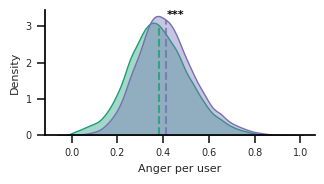

In [ ]:
def plot_user_kde(ax, top_users):
    group_colors = {"Trustworthy": "#1b9e77", "Untrustworthy": "#7570b3"}
    stats_text = []

    for group, color in group_colors.items():
        rating_data = top_users[top_users['group'] == group]
        n_users = rating_data.author_id.nunique()
        group_data = top_users[top_users['group'] == group]["user_anger"].dropna()
        avg_value = group_data.mean()  

        sns.kdeplot(group_data, color=color, ax=ax, fill=True, alpha=0.4, label=group.capitalize())
        kde = gaussian_kde(group_data)
        density_at_mean = kde(avg_value)
        
        ax.vlines(avg_value, ymin=0, ymax=density_at_mean, color=color, 
                linestyle="--", linewidth=1.5, alpha=0.8)

        stats_text.append(f"{avg_value:.2f}, n={n_users}")

    ax.set_xlabel("Anger per user", fontsize=8)
    ax.set_ylabel("Density", fontsize=8)

    ax.tick_params(axis="both", 
                    which="major", 
                    labelsize=7)
    custom_plots(ax=ax)

fig, ax = plt.subplots(figsize=(3.5, 2))
plot_user_kde(ax, top_users)
ax.text(0.45, 1, "***", transform=ax.transAxes, fontsize=8, 
            fontweight='bold',
            verticalalignment='top', color="black")   
plt.tight_layout()
plt.show()

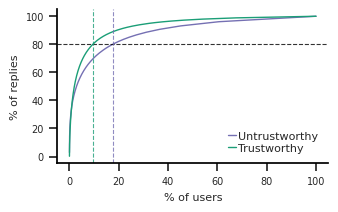

In [32]:
def plot_cdist(ax, untrust_users, trust_users, 
               untrust_perc, trust_perc):
    ax.plot(untrust_users["user_perc"], untrust_users["cum_perc"], 
            label="Untrustworthy", 
            color="#7570b3", 
            linewidth=1)  
    ax.plot(trust_users["user_perc"], trust_users["cum_perc"], 
            label="Trustworthy", 
            color="#1b9e77", 
            linewidth=1)

    ax.axhline(80, color="black", linestyle="--", 
                alpha=0.8, linewidth=0.8)
    ax.axvline(untrust_perc, color="#7570b3", 
                linestyle="--", alpha=0.8, linewidth=0.8)
    ax.axvline(trust_perc, color="#1b9e77", 
                linestyle="--", alpha=0.8, linewidth=0.8)

    ax.set_xlabel("% of users", fontsize=8)
    ax.set_ylabel("% of replies", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.legend(fontsize=8, frameon=False, 
            handlelength=0.75,
                handletextpad=0.2, labelspacing=0.2)
    
    custom_plots(ax=ax)
    return ax

fig, ax = plt.subplots(figsize=(3.5, 2))
plot_cdist(ax, untrust_users, trust_users,
           untrust_perc, trust_perc)
plt.show()

In [1]:
trustworthy_color = '#27ae60'
untrustworthy_color = '#7570b3'
same_color = '#d95f02'

def plot_same_coeffs(ax, 
                     coeffs,
                     color,
                     custom_plots=None):
    dvs = coeffs['DV'].unique()
    ivs = coeffs['IV'].unique()

    # STEP 1: Plot confounders
    categorical_data = coeffs[coeffs['IV'] != 'Rating'].copy()
    other_ivs = [iv for iv in ivs if iv != 'Rating']

    other_iv_positions = {iv: i for i, iv in enumerate(other_ivs)}
    dv_positions = {dv: i for i, dv in enumerate(dvs)}
    colors_map = ["#08519c", "#d95f02", "#bd0026"]  # Blue - Orange - Red

    cmap = LinearSegmentedColormap.from_list('blue_orange_red', colors_map, N=100)

    vmin_absolute = -0.5
    vmax_absolute = 0.5

    if not categorical_data.empty:
        colors = []
        for est in categorical_data['Estimate']:
            normalized = (est - vmin_absolute) / (vmax_absolute - vmin_absolute)
            color = cmap(normalized)[:3]
            colors.append(color)

        # size mapping based on magnitude
        base_radius = 0.1
        max_radius = 0.225
        effect_magnitudes = categorical_data['Estimate'].abs()
        normalized_magnitudes = effect_magnitudes / effect_magnitudes.max()
        radii = base_radius + (max_radius - base_radius) * normalized_magnitudes

        for idx, (i, row) in enumerate(categorical_data.iterrows()):
            x = other_iv_positions[row['IV']]
            y = dv_positions[row['DV']]
            
            radius = radii.iloc[idx]  
            circle = plt.Circle((x, y), 
                                radius=radius,
                                facecolor=colors[idx],
                                edgecolor='none',
                                linewidth=0)
            ax.add_patch(circle)
            
            if row['Symbol'] and row['Symbol'] != '':
                ax.text(x, y + 0.15, row['Symbol'],
                        fontweight='bold',
                    ha='center', va='bottom', fontsize=7)

    # STEP 2: Forest plot for main effect
    rating_data = coeffs[coeffs['IV'] == 'Rating'].copy()

    if not rating_data.empty:
        forest_start = len(other_ivs) - 0.8  
        forest_width = 1.8
        forest_center = forest_start + forest_width/2
        scale_factor = forest_width / 0.06
        
        def effect_to_forest_pos(effect_value):
            return forest_center + (effect_value * scale_factor)
        
        for i, row in rating_data.iterrows():
            y = dv_positions[row['DV']]
            estimate = row['Estimate']
            ci_lower = row['pLL']
            ci_upper = row['pUL']
            
            x_estimate = effect_to_forest_pos(estimate)
            x_lower = effect_to_forest_pos(ci_lower)
            x_upper = effect_to_forest_pos(ci_upper)
            
            normalized = (estimate - vmin_absolute) / (vmax_absolute - vmin_absolute)
            color = cmap(normalized)[:3]
            
            radius = 0.07
            triangle = Polygon(
                [(x_estimate, y + radius), (x_estimate - radius*0.8, y - radius), (x_estimate + radius*0.8, y - radius)],
                closed=True,
                facecolor=color,
                edgecolor=color,
                linewidth=0.5
            )
            ax.add_patch(triangle)
            
            ax.plot([x_lower, x_upper], [y, y], color=color,linewidth=1)
            ax.plot([x_lower, x_lower], [y-0.06, y+0.06], color=color, # change size of cap 
                    linewidth=1)
            ax.plot([x_upper, x_upper], [y-0.06, y+0.06], color=color, linewidth=1)
            
            if row['Symbol'] and row['Symbol'] != '':
                ax.text(x_estimate, y + 0.15, row['Symbol'],
                        fontweight='bold',
                    ha='center', va='bottom', fontsize=7)

        
        tick_positions = [
            effect_to_forest_pos(-0.01),  # Left
            effect_to_forest_pos(0.05)    # Right
        ]
        tick_labels = ["-0.01","0.05"]

        
        y_label_position = ax.get_ylim()[0] - 0.5
        for pos, label in zip(tick_positions, tick_labels):
            ax.text(pos, y_label_position, label, 
                ha='center', va='top', fontsize=6,
                transform=ax.transData)
            ax.axvline(x=pos,
            ymin=-0.01,  
            ymax=0, 
            color='black', 
            linewidth=0.9, 
            clip_on=False)

    if not rating_data.empty:
        ax.axvline(x=tick_positions[0]-0.3,
                color='gray', 
                linestyle='--', 
                alpha=0.5, 
                linewidth=0.9)

    zero_pos = effect_to_forest_pos(0)

    rating_label_position = ax.get_ylim()[0] - 0.6
    ax.text(zero_pos, rating_label_position, "Rating", 
            ha='center', va='top', fontsize=7,
            rotation=25,
            transform=ax.transData)
    ax.axvline(x=zero_pos,
                color='gray', linestyle=':', alpha=0.5, linewidth=0.9)

    target_position = zero_pos 
    ax.axvline(x=target_position, 
            ymin=-0.025,  
            ymax=0, 
            color='black', linewidth=0.9, clip_on=False)
    # set  main axis
    ax.set_xlim(-0.35, forest_start + forest_width + 0.75)
    ax.set_ylim(-0.5, len(dvs) - 0.5)
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_xticks(range(len(other_ivs)))
    ax.set_xticklabels(other_ivs, rotation=25, ha='right', fontsize=7)

    ax.set_yticks(range(len(dvs)))
    ax.set_yticklabels(dvs, fontsize=7)

    ax.set_xlabel('in news posts', fontsize=8, labelpad=-3)
    ax.xaxis.set_label_coords(0.25, -0.25)
    ax.set_ylabel('\t$M_{diff}$ in replies (within user)', fontsize=8, labelpad=-3)
    ax.set_axisbelow(True)

    im = ax.scatter([], [], c=[], vmin=vmin_absolute, vmax=vmax_absolute, cmap=cmap)
    cbar = plt.colorbar(im, ax=ax, shrink=0.5, aspect=20, pad=0.05)
    cbar.ax.set_position([0.78, 0.6, 0.02, 0.3]) 
    cbar.set_label('', rotation=270, labelpad=15, fontsize=7)
    cbar.outline.set_visible(False)
    cbar.set_ticks([-0.5, 0, 0.5])
    cbar.set_ticklabels(['-0.5', '0', '0.5'])
    cbar.ax.tick_params(labelsize=6)

    plt.figtext(0.5, 0.9, '*** p<0.001, ** p<0.01, * p<0.05', 
            fontsize=6, style='italic')

    custom_plots(ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    return ax
fig, ax = plt.subplots(figsize=(5.5, 2))
plot_same_coeffs(ax, 
                 merged_ratings,
                 same_color, 
                 custom_plots=custom_plots)
plt.show()

NameError: name 'plt' is not defined

/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/luehring/.conda/envs/twarcing-empty/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


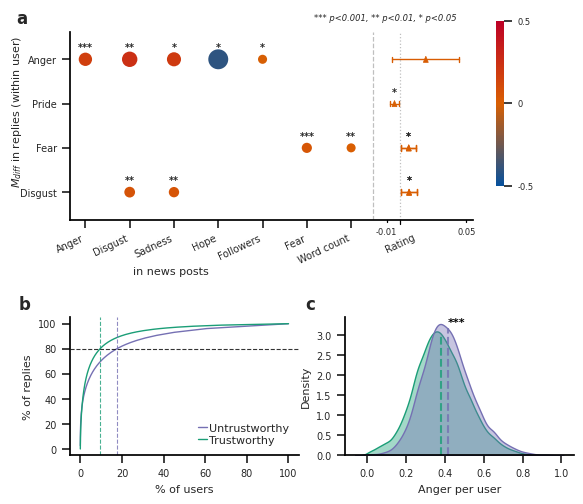

In [ ]:
fig = plt.figure(figsize=(6.5, 5.5))

gs = fig.add_gridspec(2, 2, 
                      width_ratios=[1, 1], 
                      height_ratios=[0.75, 0.55],
                      hspace=0.6,
                      wspace=0.2
                      )

# Panel A: Same responder coefficients
ax1 = fig.add_subplot(gs[0, :])
plot_same_coeffs(ax1, same_coeffs,
                 same_color, 
                 custom_plots=custom_plots)

ax1.set_title(label='a', x=-0.12, y=1, fontsize=12, 
              fontweight='bold')

# Panel B. Cumulative plots 
ax2 = fig.add_subplot(gs[1, 0])

plot_cdist(ax2, untrust_users, trust_users,
           untrust_perc, trust_perc)

ax2.set_title(label='b', x=-0.2, y=1, fontsize=12, 
              fontweight='bold')

# Panel C: KDE plots
ax3 = fig.add_subplot(gs[1, 1])

plot_user_kde(ax3, top_users)
ax3.text(0.45, 1, "***",
        transform=ax3.transAxes, 
        fontsize=8, 
        fontweight='bold',
        verticalalignment='top', 
        color="black")   

ax3.set_title('c', 
                x=-0.15, y=1, 
                fontsize=12,
                fontweight='bold')

plt.savefig("selection_effects.pdf", 
        dpi=300,
        bbox_inches='tight')

plt.show()